In [1]:
import pickle
import matplotlib.pyplot as plt

$$ \frac{dx}{d \tau} = rx (1-x/k) - \frac{x^2}{1+x^2}$$

can be rewritten into

$$ \frac{d x}{d \tau} = f(x)\left(\rho - g(x, k)\right) $$
where

 $$f(x) = -\frac{x} {(1+x^2)}\quad \text{for } x>0$$ 
 $$g(x,k) = \frac{r}{k} (1+x^2)(k-x)$$

In [2]:
paths =[
    "seed_1234_noise_0.05_sample_rate_10_lr_0.1_n_epochs_300_f_dim_6_g_dim_2_patience_100_log.pkl",
    "seed_1234_noise_0.1_sample_rate_10_lr_0.1_n_epochs_300_f_dim_6_g_dim_2_patience_100_log.pkl",
    "seed_1234_noise_0.2_sample_rate_10_lr_0.1_n_epochs_300_f_dim_6_g_dim_2_patience_100_log.pkl"
]

In [3]:
logs = []
for path in paths:
    with open(path, 'rb') as file:
        logs.append(pickle.load(file))

In [42]:
for log in logs:
    print(log["losses"][-5:])

[0.06308609992265701, 0.06386882066726685, 0.06358172744512558, 0.06313411146402359, 0.0634135901927948]
[0.07707411795854568, 0.07262987643480301, 0.09034564346075058, 0.08838668465614319, 0.111674964427948]
[0.14228110015392303, 0.10886881500482559, 0.19615711271762848, 0.10911031067371368, 0.12879689037799835]


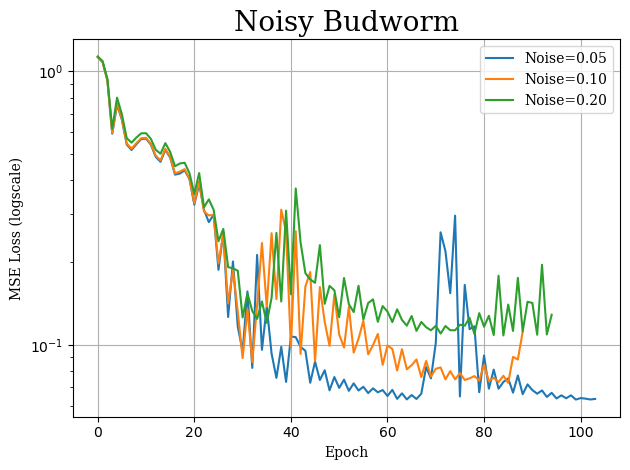

In [103]:
noises = [0.05, 0.1, 0.2]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
for idx, log in enumerate(logs):
    plt.plot(log["losses"], label = f"Noise={noises[idx]:.2f}", color = colors[idx])
plt.yscale('log')
plt.ylabel("MSE Loss (logscale)", family='serif')
plt.xlabel("Epoch", family ='serif')
plt.legend(prop={'family': 'serif'})
plt.grid(True)
plt.title(r"Noisy Budworm", family='serif',size=20)
plt.tight_layout()
plt.savefig("elu_noisy_budworm_losses.png")
plt.show()

# Load data from `train_budworm.py`

In [7]:
from stabnode.node import _load_model_opt, set_global_seed
from data.budworm import simulate_steady_state
from sympy import symbols, Eq, solve, simplify
import numpy as np
import torch

from sklearn.preprocessing import MinMaxScaler
device= "cpu"

In [12]:
r=0.56
def g_true_func(x,k):
    return (r/k) *(1+x**2)*(k-x)

def f_true_func(x):
    return - x / (1+x**2)

In [14]:

def get_roots():
    """
    roots of descriminant of associated ode cubic in k.
    """
    r, k = symbols('r k', positive=True)
    a = r/k
    b = -r
    c = (k+r)/k
    d = -r
    p = (3*a*c-b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)
    
    D = - (4*p**3 + 27*q**2)
    D = simplify(D)
    
    
    D_fixed = D.subs(r, 0.56)
    r1, r2 = solve(Eq(D_fixed, 0), k)
    return r1, r2

def load_data(noise):
    seed=1234
    sample_rate = 10
    set_global_seed(seed = seed)

    r1, r2 = get_roots()
    k_vals = np.linspace(float(r1)-1, float(r2)+1,250)


    x0 = 1

    k_start = k_vals[0]
    k_end = k_vals[-1]
    n_points = 250
    
    k_increase = np.linspace(k_start,k_end, n_points)
    k_decrease = np.linspace(k_increase[-1],k_start,n_points)

    x_increase = simulate_steady_state(k_increase,x0=x0, show_progress=False)
    x_decrease = simulate_steady_state(k_decrease, x0=x_increase[-1], show_progress=False)

    X = np.hstack((x_increase,x_decrease))
    K = np.hstack((k_increase, k_decrease))

    repeat = 2
    for _ in range(repeat):
        X = np.hstack((X,X))
        K = np.hstack((K,K))
    
    tau = torch.arange(0, len(K), device = device)

        
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_scaled = scaler.fit_transform(X.reshape(-1,1))
    X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)

    tau_train = tau[::sample_rate]
    X_train = X_scaled[tau_train]
    K_train = K[tau_train]

    noise_arr = torch.randn_like(X_train) * noise
    X_train = X_train + noise_arr

    def K_func(tau):
        idx = int(tau) % len(K)
        return torch.tensor(K[idx],dtype=torch.float32, device=device)
    
    return X, K, tau, scaler, X_scaled, tau_train, X_train, K_train, K_func

def evaluate_model(model, X, K, tau, scaler, X_scaled, tau_train, X_train, K_train, K_func):
    g = model.g
    f = model.f
    
    g.eval()
    f.eval()
    
    g_true_out = []
    g_pred_out = []
    
    f_true_out = []
    f_pred_out = []
    # print(tau)
    for tau_i in tau:
    
        Ki = K_func(tau_i).reshape(-1,1)
        xi = X_scaled[tau_i].reshape(-1,1)
        xi_unscaled = X[tau_i].reshape(-1,1)

        # print(Ki, type(Ki))
        # print(Ki.numpy()[0,0])
        # print(xi_unscaled, type(xi_unscaled))
        # print(type(g_true))
        g_true_out.append(g_true_func(xi_unscaled,Ki.detach().numpy()[0,0]))
        f_true_out.append(f_true_func(xi_unscaled))
    
        with torch.no_grad():
            g_pred_out.append(g(xi,Ki).detach().cpu().numpy())
            f_pred_out.append(f(xi).detach().cpu().numpy())
    
    g_true_out = np.array(g_true_out).reshape(-1)
    g_pred_out = np.array(g_pred_out).reshape(-1)
    
    f_true_out = np.array(f_true_out).reshape(-1)
    f_pred_out = np.array(f_pred_out).reshape(-1)
    
    finite_idx = np.isfinite(g_true_out)
    g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)

    finite_idx = np.isfinite(f_true_out)
    f_true_scaled = scaler.transform(f_true_out[finite_idx].reshape(-1,1)).reshape(-1)

    L2_rel_err = np.linalg.norm(g_true_scaled - g_pred_out) / np.linalg.norm(g_true_scaled)
    L2_rel_err_f = np.linalg.norm(f_true_scaled - f_pred_out) / np.linalg.norm(f_true_scaled)

    return g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err, f_true_scaled, f_pred_out, f_true_out, L2_rel_err_f

In [15]:
model_paths = [
    "seed_1234_noise_0.05_sample_rate_10_lr_0.1_n_epochs_300_f_dim_6_g_dim_2_patience_100.pt",
    "seed_1234_noise_0.1_sample_rate_10_lr_0.1_n_epochs_300_f_dim_6_g_dim_2_patience_100.pt",
    "seed_1234_noise_0.2_sample_rate_10_lr_0.1_n_epochs_300_f_dim_6_g_dim_2_patience_100.pt"
]
noises = [0.05, 0.1, 0.2]

In [16]:
g_true = []
g_pred = []
l2_g = []
tau_arr = []
train_arr = []
f_true = []
f_pred = []
l2_f = []


for path, noise in zip(model_paths,noises):
    model, *_ = _load_model_opt(path)
    (g_true_scaled,
     g_pred_out,
     tau_train, 
     X_train,
     L2_rel_err, 
     f_true_scaled, 
     f_pred_out, 
     f_true_out,
     L2_rel_err_f) = evaluate_model(model,*load_data(noise))

    g_true.append(g_true_scaled)
    g_pred.append(g_pred_out)
    l2_g.append(L2_rel_err)

    f_true.append(f_true_scaled)
    f_pred.append(f_pred_out)
    l2_f.append(L2_rel_err_f)

    tau_arr.append(tau_train)
    train_arr.append(X_train)
    

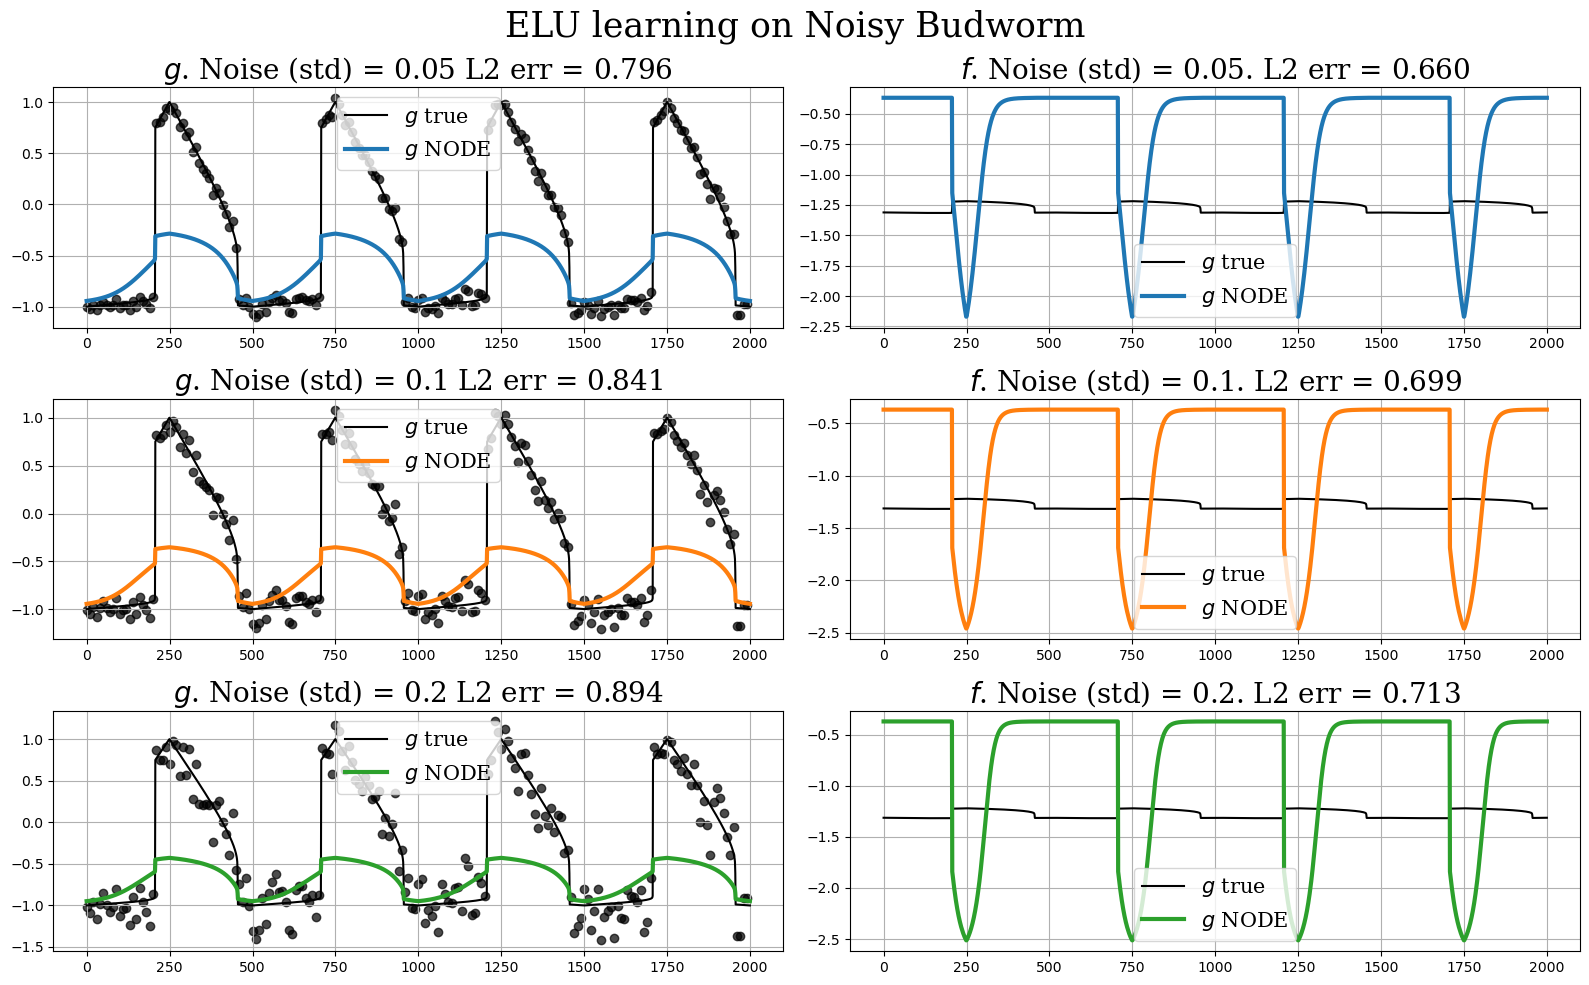

In [100]:
idx = 2


fig, ax = plt.subplots(3,2, figsize=(16,10))
ax = ax.flatten()
for ax_idx in range(len(ax)):
    if ax_idx % 2 == 0:
        idx = ax_idx  // 2
        ax[ax_idx].plot(g_true[idx], label = r"$g$ true",c='black')
        ax[ax_idx].plot(g_pred[idx], label = r"$g$ NODE",c=colors[idx],lw=3)
        ax[ax_idx].scatter(tau_arr[idx], train_arr[idx],c='black',alpha=0.7)
        ax[ax_idx].set_title( rf"$g$. Noise (std) = {noises[idx]} L2 err = {l2_g[idx]:.3f}", family='serif',size=20)
        ax[ax_idx].grid(True)
        ax[ax_idx].legend(prop={'family':'serif', 'size':15})
    else:
        idx = (ax_idx -1) // 2
        ax[ax_idx].plot(f_true[idx], label = r"$g$ true",c='black')
        ax[ax_idx].plot(f_pred[idx],label = r"$g$ NODE",c=colors[idx],lw=3)
        ax[ax_idx].set_title(rf"$f$. Noise (std) = {noises[idx]}. L2 err = {l2_f[idx]:.3f}", family='serif', size=20)
        ax[ax_idx].grid(True)
        ax[ax_idx].legend(prop={'family':'serif', 'size':15})
plt.suptitle(f"ELU learning on Noisy Budworm",size=25,family='serif')
plt.tight_layout()
plt.savefig("elu_noisy_budworm.png")
plt.show()